In [50]:
import numpy as np
import pandas as pd

In [131]:
import numpy as np
import pandas as pd

# ログ表示
class Log:
    # 表示ログレベル
    Loglevel = 0
    def logLevelset(level):
        # 表示ログレベルの設定
        Log.Loglevel = level
    def log_print(level, std, *variable):
        if(Log.Loglevel >= level):
            if(len(variable) == 0):
                print(std)
            else:
                for i in range(len(variable)):
                    index = std.find("}") + 1
                    # 改行なし表示
                    print(std[:index].format(variable[i]), end='')
                    # 表示した分を削除
                    std = std.replace(std[:index], "", 1)
                # 改行表示
                print(std)

In [132]:
Log.logLevelset(0)

In [158]:
class ScratchDeepNeuralNetrowkRegressor:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose=True, lr=1e-10, num_epoch=100, batch_size=1460, sigma=1e-4, n_nodes1=10, n_nodes2=5, n_output=1):
        self.verbose = verbose
        self.lr = lr
        self.num_epoch = num_epoch # epoch回数
        self.batch_size = batch_size # バッチサイズ
        self.sigma = sigma
        self.n_features = 0
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力数（3層目のノード数）
        self.cost = []
        
        # レイヤーのインスタンス
        self.FC1 = None
        self.FC2 = None
        self.FC3 = None
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
    
    def fit(self, X, y, X_val=None, y_val=None):
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        
        # array変換
        X = np.array(X)
        y = np.array(y)
        
        # ミニバッチ生成
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
                
        """
        初期化処理
        """
        self.n_features = X.shape[1]
        
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Identity()
        
        # エポック数分繰り返す
        for epoch in range(self.num_epoch):
            #print(epoch)
            for i, (mini_X, mini_y) in enumerate(get_mini_batch):
                """
                フォワードプロパゲーション
                """
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                """
                フォワードプロパゲーション
                """
                dA3 = self.activation3.backward(Z3, y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
            # 平均二乗誤差
            loss = MSE.calculation(Z3)
            self.cost.append(loss)
            
    def predict(self, X):
        # array変換
        X = np.array(X)
        
        get_mini_batch = GetMiniBatch(X, X, batch_size=10)
        
        for i, (mini_X, mini_y) in enumerate(get_mini_batch):
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
        return Z3

In [159]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        Log.log_print(1, "self.W.shape{}", self.W.shape)
        Log.log_print(2, "self.W{}", self.W)
        self.B = initializer.B(n_nodes2)
        Log.log_print(1, "self.B.shape{}", self.B.shape)
        Log.log_print(2, "self.B{}", self.B)   
        self.forward_x = 0
        self.dZ = 0
        self.dA = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.forward_x = X.copy()
        Log.log_print(2, "self.forward_x{}", self.forward_x)
        Log.log_print(1, "self.forward_x.shape{}", self.forward_x.shape)
        A = np.dot(X, self.W) + self.B
        Log.log_print(1, "A.shape{}", A.shape)
        Log.log_print(2, "A{}", A)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        Log.log_print(1, "更新前")
        Log.log_print(1, "self.B{}", self.B.shape)
        Log.log_print(1, "self.W{}", self.W.shape)
        
        self.dA = dA
        Log.log_print(1, "self.dA.shape{}", self.dA.shape)
        
        self.dZ = np.dot(dA, self.W.T)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape)
        
        Log.log_print(2, "self.dZ{}", self.dZ)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape)
        
        # 更新
        #self = self.optimizer.update(self)
        self.optimizer.update(self)
        
        Log.log_print(1, "更新後")
        Log.log_print(1, "self.B{}", self.B.shape)
        Log.log_print(1, "self.W{}", self.W.shape)
        
        return self.dZ

In [160]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    function : std
      初期関数のモード
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [177]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W + self.lr/layer.dA.shape[0]*np.dot(layer.forward_x.T, layer.dA)
        layer.B = layer.B + self.lr*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape)
        Log.log_print(2, "layer.W{}", layer.W)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape)
        Log.log_print(2, "layer.B{}", layer.B)
        
        #return layer

In [162]:
class AddGrand:
    """
    最適劣勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.HW = layer.HW + layer.W**2
        layer.HB = layer.HB + np.mean(layer.B**2, axis=1)[np.newaxis,:]
        
        layer.W = layer.W - self.lr*(1/np.sqrt(layer.HW))*np.dot(layer.forward_x.T, layer.dA) / layer.dA.shape[0]
        layer.B = layer.B - self.lr*(1/np.sqrt(layer.HB))*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape)
        Log.log_print(2, "layer.W{}", layer.W)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape)
        Log.log_print(2, "layer.B{}", layer.B)
        
        return layer

In [163]:
class Tanh:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dA = dZ *(1 - np.tanh(self.A)**2)
        Log.log_print(1, "dA.shape{}", dA.shape)
        Log.log_print(2, "dA{}", dA)
        return dA

In [164]:
class ReLU:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.maximum(A, 0)
    
    def backward(self, dZ):
        A = self.A.copy()
        A[A>0]=1
        A[A<=0]=0
        dA = dZ *A
        Log.log_print(1, "dA.shape{}", dA.shape)
        Log.log_print(2, "dA{}", dA)
        return dA

In [165]:
class Identity:
    def __init__(self):
        pass
    
    def forward(self, A):
        return A
    
    def backward(self, Yhat, Y):
        return Yhat - Y

In [166]:
class MSE:
    @classmethod
    def calculation(self, loss):
        return np.mean((loss)**2) / 2

In [167]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)または(n_samples,)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード

    Retruns
    ----------
    for文で呼び出すと以下の2つを返す。最後のイテレーションでは、バッチサイズより小さいこともある。
    mini_X : 次の形のndarray, shape (batch_size, n_features)
      学習データのミニバッチ
    mini_y : 次の形のndarray, shape (batch_size, 1)または(batch_size,)
      正解値のミニバッチ
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        # ランダムに並べ換える
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._counter = 0
        # イテレーション数を計算する
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        # len()が使われたときの処理
        return self._stop

    def __iter__(self):
        return self

    def __next__(self):
        # for文で呼ばれた際のループごとの処理
        if self._counter >= self._stop:
            # 最後まで進んだら終了
            self._counter = 0
            raise StopIteration()

        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [168]:
data = pd.read_csv("./House_Prices/train.csv")
X = data[["GrLivArea", "YearBuilt"]]
y = data[["SalePrice"]]

In [64]:
NW = ScratchDeepNeuralNetrowkRegressor()

In [65]:
NW.fit(X, y)

In [42]:
NW.predict(X)

array([[208500.],
       [181500.],
       [223500.],
       ...,
       [266500.],
       [142125.],
       [147500.]])

In [45]:
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


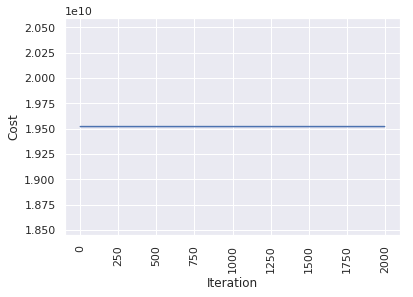

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(NW.cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
7.07015212e-05
7.06992912e-05
7.06948314e-05

In [178]:
NW2 = ScratchDeepNeuralNetrowkRegressor()
NW2.fit(X, y)


layer.W[[ 7.07059813e-05]
 [-2.49258854e-05]
 [-1.15888876e-04]
 [ 5.15953598e-06]
 [-2.74503498e-05]]
db0.00011909652336087256
layer.W[[-4.65020338e-05  1.19697317e-05  5.22751524e-05  2.54056304e-05
  -2.17701597e-04]
 [ 3.67040989e-05  3.32865519e-05 -4.95876962e-05  9.41147539e-06
   3.82036205e-05]
 [-1.80080648e-04  4.62791596e-05 -1.42999772e-05  2.62254474e-05
   1.00558505e-05]
 [ 1.50065633e-04 -4.74302600e-06 -7.46070477e-05 -1.38334940e-04
  -2.87390340e-05]
 [-1.87315077e-04 -1.00625155e-04 -2.12156687e-05 -1.21710710e-04
   1.59487912e-05]
 [-1.71469113e-04  2.18521676e-05  1.31477013e-04  2.82197307e-05
  -8.40082233e-05]
 [-9.79970985e-05  2.72202191e-05  1.14944061e-04 -1.40832679e-04
   9.63107861e-06]
 [-4.71279828e-06 -8.95927568e-05  1.20207182e-04 -2.44402481e-05
   1.81982518e-05]
 [-1.33840988e-04 -5.16967339e-05 -6.60831583e-05  3.05399225e-05
  -1.52986849e-04]
 [-7.05335313e-05 -2.19112378e-04  9.25898380e-06 -1.27612777e-04
   6.34618207e-05]]
db3.329315720

layer.W[[-4.65031707e-05  1.19701318e-05  5.22770148e-05  2.54055475e-05
  -2.17701155e-04]
 [ 3.67253666e-05  3.32790660e-05 -4.96225349e-05  9.41302546e-06
   3.81953609e-05]
 [-1.80101599e-04  4.62865339e-05 -1.42656577e-05  2.62239205e-05
   1.00639869e-05]
 [ 1.50063934e-04 -4.74242810e-06 -7.46042651e-05 -1.38335064e-04
  -2.87383743e-05]
 [-1.87331331e-04 -1.00619434e-04 -2.11890433e-05 -1.21711895e-04
   1.59551035e-05]
 [-1.71483425e-04  2.18572051e-05  1.31500457e-04  2.82186876e-05
  -8.40026652e-05]
 [-9.79970656e-05  2.72202076e-05  1.14944007e-04 -1.40832677e-04
   9.63106584e-06]
 [-4.70710987e-06 -8.95947590e-05  1.20197863e-04 -2.44398335e-05
   1.81960426e-05]
 [-1.33846131e-04 -5.16949236e-05 -6.60747335e-05  3.05395477e-05
  -1.52984852e-04]
 [-7.05308288e-05 -2.19113330e-04  9.25455686e-06 -1.27612580e-04
   6.34607711e-05]]
db3.330619189051091e-05
layer.W[[ 1.02261106e-04 -1.47911443e-04  1.90117006e-04 -8.73553241e-05
  -8.17584331e-06  1.17217340e-04 -1.06685256

layer.W[[-4.65041929e-05  1.19704906e-05  5.22786874e-05  2.54054732e-05
  -2.17700758e-04]
 [ 3.67444761e-05  3.32723600e-05 -4.96538044e-05  9.41441497e-06
   3.81879348e-05]
 [-1.80120425e-04  4.62931402e-05 -1.42348531e-05  2.62225516e-05
   1.00713027e-05]
 [ 1.50062412e-04 -4.74189387e-06 -7.46017741e-05 -1.38335175e-04
  -2.87377827e-05]
 [-1.87345936e-04 -1.00614309e-04 -2.11651443e-05 -1.21712957e-04
   1.59607793e-05]
 [-1.71496288e-04  2.18617190e-05  1.31521505e-04  2.82177523e-05
  -8.39976665e-05]
 [-9.79970404e-05  2.72201987e-05  1.14943966e-04 -1.40832675e-04
   9.63105607e-06]
 [-4.70200142e-06 -8.95965517e-05  1.20189504e-04 -2.44394621e-05
   1.81940574e-05]
 [-1.33850751e-04 -5.16933023e-05 -6.60671734e-05  3.05392118e-05
  -1.52983056e-04]
 [-7.05284013e-05 -2.19114181e-04  9.25058464e-06 -1.27612403e-04
   6.34598278e-05]]
db3.33178816338996e-05
layer.W[[ 1.02264831e-04 -1.47916938e-04  1.90127405e-04 -8.73759476e-05
  -8.16692146e-06  1.17241720e-04 -1.04353833e

In [179]:
NW2.cost

[9.409060172876785e-09,
 7.090860763452206e-09,
 5.099986188505786e-09,
 3.436436448137643e-09,
 2.100211542447893e-09,
 1.0913114715366571e-09,
 4.097362355040532e-10,
 5.548583445020056e-11,
 2.8560268475218547e-11,
 3.2895953767922675e-10,
 9.566836421623452e-10,
 1.911732582024694e-09,
 3.194106357366394e-09,
 4.803804968287565e-09,
 6.74082841488833e-09,
 9.005176697268807e-09,
 1.1596849815529121e-08,
 1.4515847769769391e-08,
 1.7762170560089742e-08,
 2.1335818186590292e-08,
 2.5236790649371167e-08,
 2.94650879485325e-08,
 3.402071008417439e-08,
 3.890365705639698e-08,
 4.411392886530039e-08,
 4.965152551098473e-08,
 5.551644699355014e-08,
 6.170869331309675e-08,
 6.822826446972466e-08,
 7.507516046353404e-08,
 8.224938129462498e-08,
 8.975092696309763e-08,
 9.757979746905206e-08,
 1.0573599281258844e-07,
 1.1421951299380693e-07,
 1.2303035801280757e-07,
 1.3216852786969058e-07,
 1.4163402256455602e-07,
 1.51426842097504e-07,
 1.6154698646863473e-07,
 1.7199445567804827e-07,
 1.8

In [145]:
NW2.predict(X)

array([[0.00194639],
       [0.00194639],
       [0.00194639],
       ...,
       [0.00194639],
       [0.00194639],
       [0.00194639]])

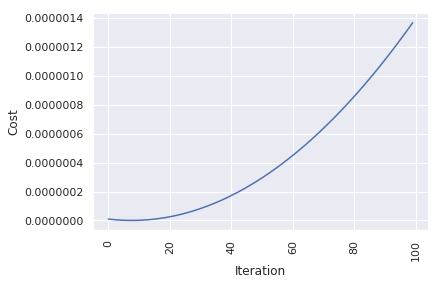

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(NW2.cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.xticks(rotation="vertical")
plt.show()